In [37]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, CSVLogger
from sklearn.utils import class_weight
import random

In [38]:
import tensorflow as tf
print("GPU Disponible:", tf.config.list_physical_devices('GPU'))

GPU Disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [39]:
# Rutas
base_dir = r"C:\Users\Tech4Diet\Desktop\GLORIA\IJCNN\Dataset_I\S_aurata" 

# Parámetros
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 64
EPOCHS = 30
SEED = 42

In [40]:
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds(SEED)

In [41]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print(f"Usando GPU: {physical_devices}")
    except Exception as e:
        print(f"Error configurando GPU: {e}")
else:
    print("No se detectó GPU, usando CPU.")

Usando GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [42]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=90,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=[0.7, 1.3],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255)
#val_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
        os.path.join(base_dir, 'train'),
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
        class_mode='categorical')

'''
val_generator = val_datagen.flow_from_directory(
        os.path.join(base_dir, 'val'),
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        seed=42)
'''
test_generator = test_datagen.flow_from_directory(
        os.path.join(base_dir, 'test'),
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        shuffle=False,  
        class_mode='categorical')

print(f"Número de imágenes de entrenamiento: {train_generator.samples}")
#print(f"Número de imágenes de validación: {val_generator.samples}")
print(f"Número de imágenes de prueba: {test_generator.samples}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Steps per epoch: {len(train_generator)}")
#print(f"Validation steps: {len(val_generator)}")

Found 1937 images belonging to 2 classes.
Found 583 images belonging to 2 classes.
Número de imágenes de entrenamiento: 1937
Número de imágenes de prueba: 583
Batch size: 64
Steps per epoch: 31


In [43]:
from sklearn.utils import class_weight 
import numpy as np

print(np.unique(train_generator.classes))

class_weights = class_weight.compute_class_weight(
           'balanced',
            classes=np.unique(train_generator.classes), 
            y=train_generator.classes)

train_class_weights = dict(enumerate(class_weights))

train_class_weights = (class_weights)

print("Pesos de las clases:", train_class_weights)

[0 1]
Pesos de las clases: [1.46299094 0.75960784]


In [44]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

for layer in base_model.layers:
    if "block_16" in layer.name:  # Identifica las capas del último bloque
        layer.trainable = True

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

# https://gist.github.com/wassname/ce364fddfc8a025bfab4348cf5de852d
def weighted_categorical_crossentropy(weights):
    def loss(y_true, y_pred):
        weights_tensor = tf.convert_to_tensor(weights, dtype=tf.float32)
        loss=tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred)
        class_weights = tf.reduce_sum(y_true * weights_tensor, axis=-1)
        weighted_loss = loss * class_weights
        return tf.reduce_mean(weighted_loss)

    return loss

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=weighted_categorical_crossentropy(train_class_weights),
    metrics=['accuracy']
)

callbacks = [
    TensorBoard(log_dir='./logs', histogram_freq=1),
    CSVLogger('training_log.csv', append=True, separator=';'),
]

In [45]:
try:
    history=model.fit(train_generator,
            #validation_data=val_generator,
            shuffle=True,
            epochs=EPOCHS,
            callbacks=callbacks)
    assert False
except Exception as e:
  print(f"Expected {type(e).__name__}: {e}")

Epoch 1/30
31/31 [==============================] - 11s 322ms/step - loss: 0.6870 - accuracy: 0.6562
Epoch 2/30
31/31 [==============================] - 10s 314ms/step - loss: 0.4195 - accuracy: 0.8085
Epoch 3/30
31/31 [==============================] - 10s 320ms/step - loss: 0.3130 - accuracy: 0.8725
Epoch 4/30
31/31 [==============================] - 10s 313ms/step - loss: 0.2710 - accuracy: 0.8973
Epoch 5/30
31/31 [==============================] - 10s 314ms/step - loss: 0.2327 - accuracy: 0.9117
Epoch 6/30
31/31 [==============================] - 10s 313ms/step - loss: 0.2084 - accuracy: 0.9257
Epoch 7/30
31/31 [==============================] - 10s 316ms/step - loss: 0.1995 - accuracy: 0.9272
Epoch 8/30
31/31 [==============================] - 10s 316ms/step - loss: 0.1751 - accuracy: 0.9432
Epoch 9/30
31/31 [==============================] - 10s 314ms/step - loss: 0.1577 - accuracy: 0.9427
Epoch 10/30
31/31 [==============================] - 10s 310ms/step - loss: 0.1643 - accura

In [46]:
# Save model
model.save('mobile_s_aurata_model.h5')

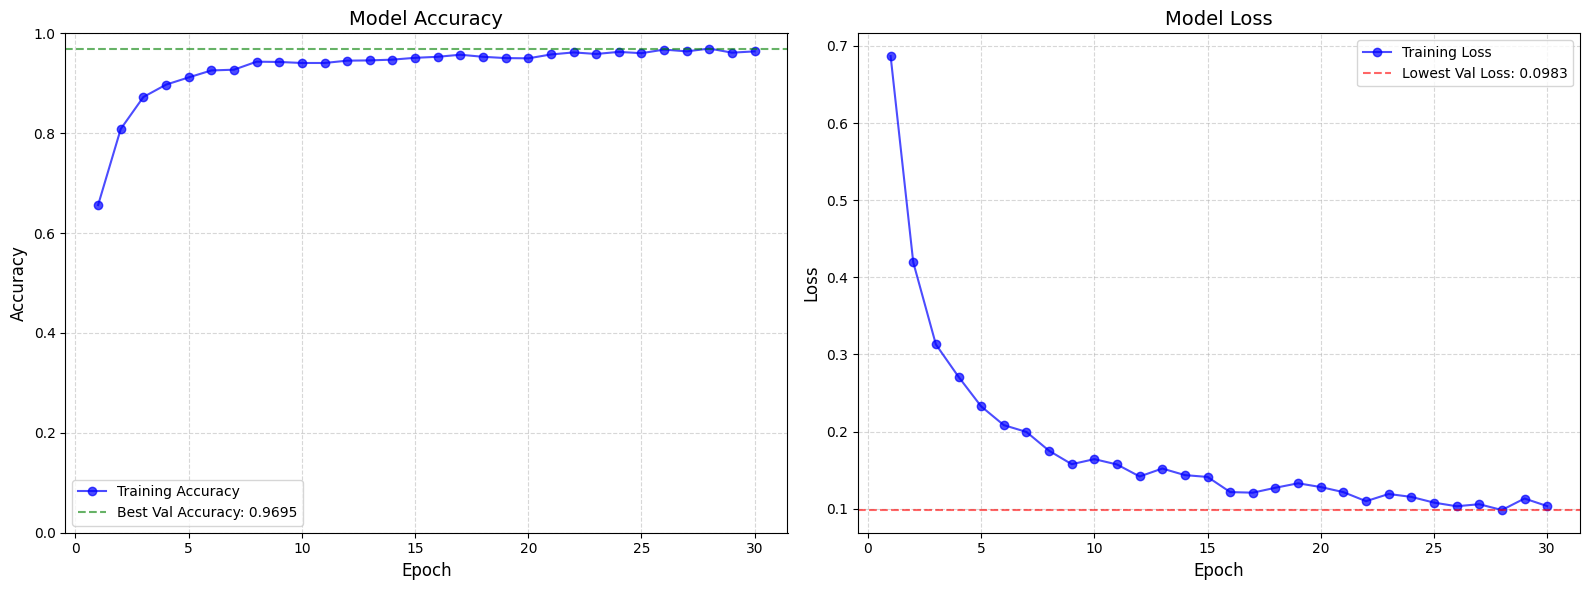

In [47]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(history):
    """
    Plot training history metrics with improved visualization.
    """
    # Obtener los datos
    epochs = range(1, len(history.history['accuracy']) + 1)
    train_acc = history.history['accuracy']
    #val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    #val_loss = history.history['val_loss']

    # Crear la figura
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Gráfica de Accuracy
    ax1.plot(epochs, train_acc, label='Training Accuracy', color='blue', linestyle='-', marker='o', alpha=0.7)
    #ax1.plot(epochs, val_acc, label='Validation Accuracy', color='orange', linestyle='-', marker='o', alpha=0.7)
    ax1.axhline(y=np.max(train_acc), color='green', linestyle='--', alpha=0.6, label=f"Best Val Accuracy: {np.max(train_acc):.4f}")
    ax1.set_title('Model Accuracy', fontsize=14)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(True, linestyle='--', alpha=0.5)
    ax1.set_ylim(0, 1)

    # Gráfica de Loss
    ax2.plot(epochs, train_loss, label='Training Loss', color='blue', linestyle='-', marker='o', alpha=0.7)
    #ax2.plot(epochs, val_loss, label='Validation Loss', color='orange', linestyle='-', marker='o', alpha=0.7)
    ax2.axhline(y=np.min(train_loss), color='red', linestyle='--', alpha=0.6, label=f"Lowest Val Loss: {np.min(train_loss):.4f}")
    ax2.set_title('Model Loss', fontsize=14)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend(fontsize=10)
    ax2.grid(True, linestyle='--', alpha=0.5)

    # Ajustar los márgenes y mostrar
    plt.tight_layout()
    plt.show()

plot_training_history(history)

10/10 [==============================] - 1s 68ms/step


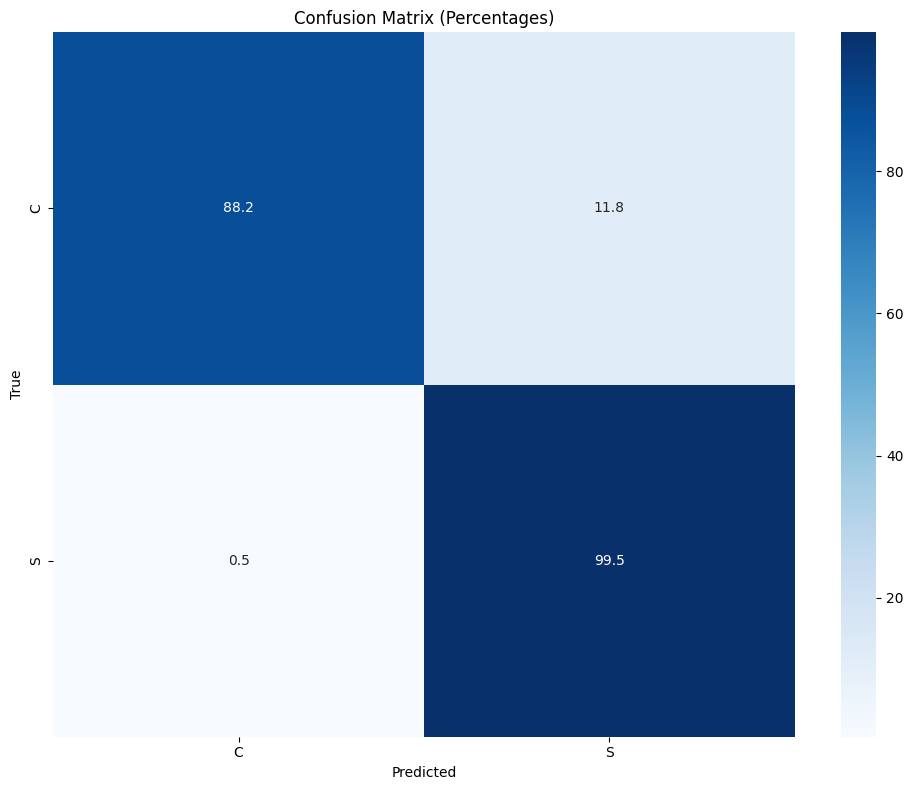


Detailed Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

           C       0.98      0.88      0.93       144
           S       0.96      1.00      0.98       439

    accuracy                           0.97       583
   macro avg       0.97      0.94      0.95       583
weighted avg       0.97      0.97      0.97       583



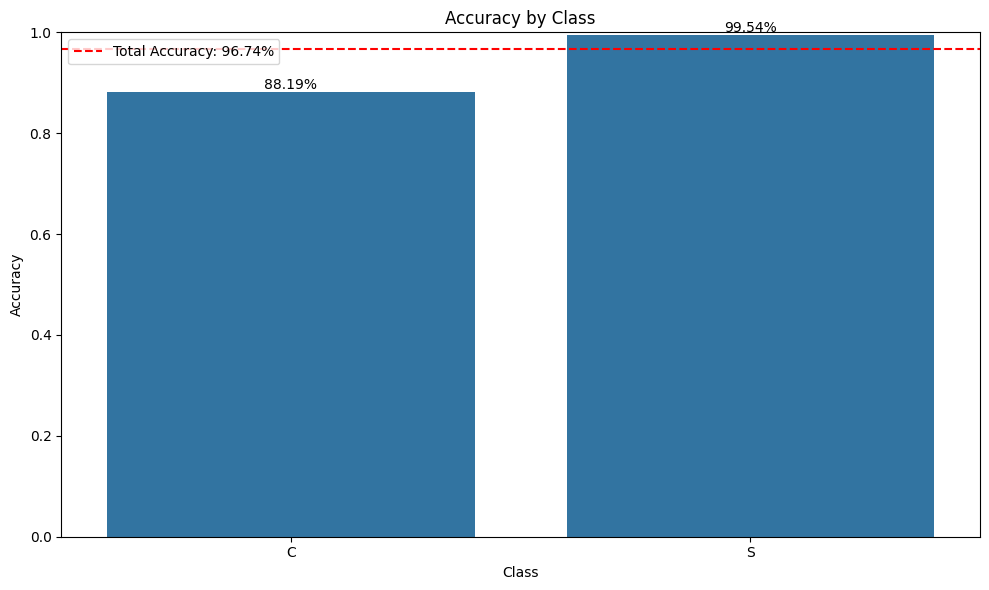

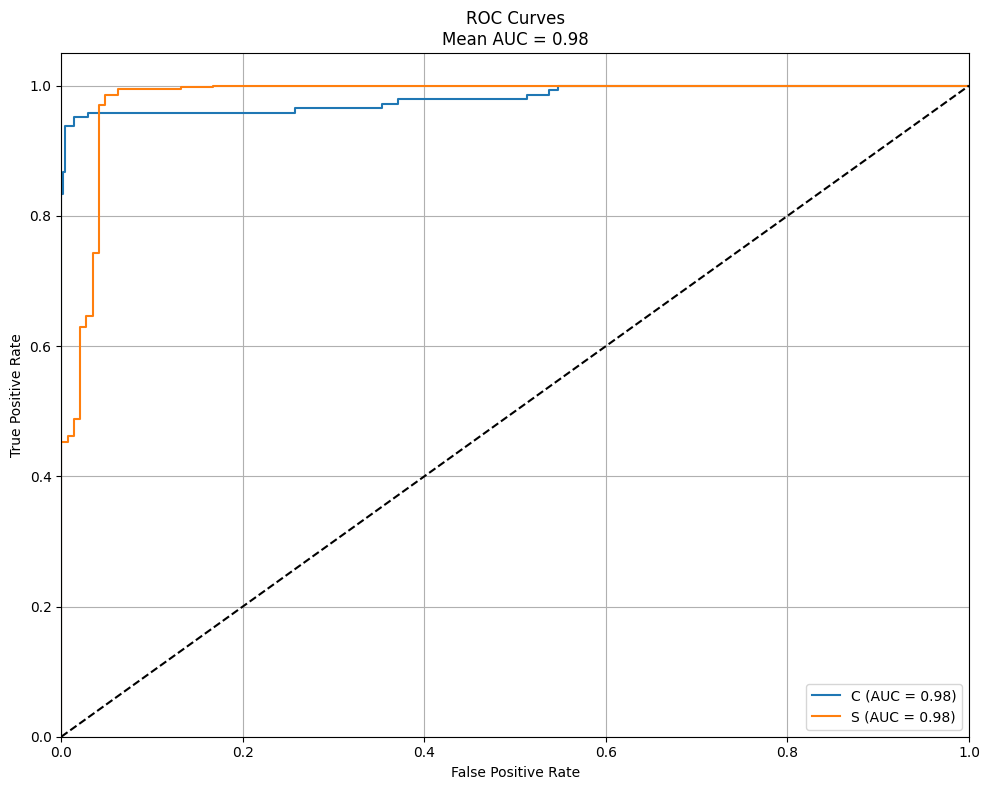


Summary Metrics:
--------------------------------------------------
Total Accuracy: 96.74%
Mean AUC: 0.98

Per-class Accuracy:
C: 88.19%
S: 99.54%


In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf

def evaluate_model(model, test_generator):
    """
    Evaluate model and generate confusion matrix and classification report
    """
    # Get predictions
    test_generator.reset()
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())
    
    # Calcular matriz de confusión
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Convertir a porcentajes
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Visualización
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_percentage, annot=True, fmt='.1f', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.title('Confusion Matrix (Percentages)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
    
    # Print classification report
    print("\nDetailed Classification Report:")
    print("-"*50)
    print(classification_report(y_true, y_pred_classes, target_names=class_labels))
    
    # Calculate per-class accuracy
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

    total_accuracy = accuracy_score(y_true, y_pred_classes)
    
    # Plot per-class accuracy
    plt.figure(figsize=(10, 6))
    bars = sns.barplot(x=class_labels, y=per_class_accuracy)
    plt.axhline(y=total_accuracy, color='r', linestyle='--', label=f'Total Accuracy: {total_accuracy:.2%}')
    plt.title('Accuracy by Class')
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    
    # Add value labels on bars
    for i, acc in enumerate(per_class_accuracy):
        plt.text(i, acc, f'{acc:.2%}', ha='center', va='bottom')
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # ROC curve for each class
    from sklearn.metrics import roc_curve, auc
    plt.figure(figsize=(10, 8))
    
    mean_auc = 0
    for i, class_name in enumerate(class_labels):
        fpr, tpr, _ = roc_curve(
            (y_true == i).astype(int),
            y_pred[:, i]
        )
        roc_auc = auc(fpr, tpr)
        mean_auc += roc_auc
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
    
    mean_auc /= len(class_labels)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves\nMean AUC = {mean_auc:.2f}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Additional metrics summary
    print("\nSummary Metrics:")
    print("-"*50)
    print(f"Total Accuracy: {total_accuracy:.2%}")
    print(f"Mean AUC: {mean_auc:.2f}")
    print("\nPer-class Accuracy:")
    for class_name, acc in zip(class_labels, per_class_accuracy):
        print(f"{class_name}: {acc:.2%}")

evaluate_model(model, test_generator)

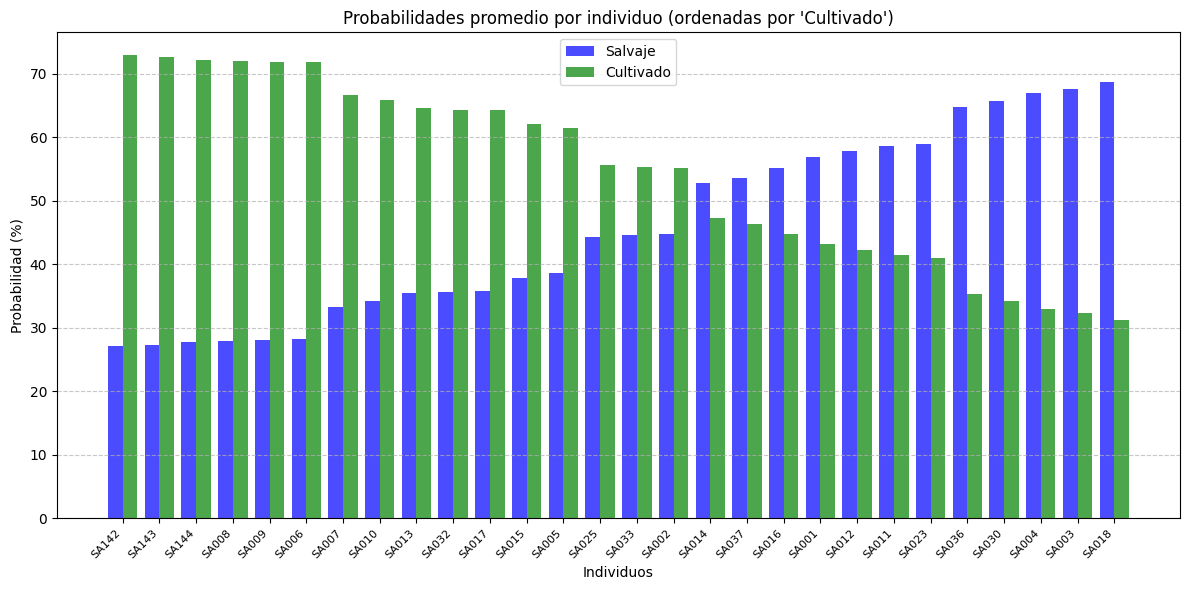

Probabilidad total de 'Salvaje': 45.67%
Probabilidad total de 'Cultivada': 54.33%


In [49]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from scipy.special import softmax
from collections import defaultdict

images_folder = r"C:\Users\Tech4Diet\Desktop\GLORIA\IJCNN\Dataset_I\S_aurata\E"
image_size = (224, 224)  # Tamaño esperado por la red

# Función para procesar imágenes
def preprocess_image(image_path, target_size):
    """Preprocesa una imagen para que sea compatible con el modelo."""
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalización
    return np.expand_dims(img_array, axis=0)

# Función para procesar imágenes
def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalización
    return np.expand_dims(img_array, axis=0)

# Extraer el identificador del individuo (parte antes de "(" en el nombre)
def get_individual_name(file_name):
    return file_name.split('(')[0].strip()

# Procesar todas las imágenes y agrupar por individuo
results = defaultdict(list)  # Diccionario para almacenar probabilidades por individuo
image_groups = defaultdict(list)  # Diccionario para agrupar nombres de archivos por individuo
for file_name in sorted(os.listdir(images_folder)):
    if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Filtrar imágenes
        individual_name = get_individual_name(file_name)  # Identificar individuo
        image_path = os.path.join(images_folder, file_name)
        processed_img = preprocess_image(image_path, image_size)
        logits = model.predict(processed_img, verbose=0)[0]  # Obtener logits
        probabilities = softmax(logits)  # Convertir logits a probabilidades
        results[individual_name].append(probabilities)  # Agrupar por individuo
        image_groups[individual_name].append(file_name)  # Almacenar nombres

# Calcular promedio de probabilidades por individuo
individual_averages = {ind: np.mean(probs, axis=0) for ind, probs in results.items()}
sorted_individuals = sorted(individual_averages.items(), key=lambda x: x[1][1], reverse=True)

# Separar nombres y probabilidades ya ordenados
individual_names = [ind for ind, _ in sorted_individuals]
wild_probabilities = [probs[0] * 100 for _, probs in sorted_individuals]  # Salvaje (%)
cultivated_probabilities = [probs[1] * 100 for _, probs in sorted_individuals]  # Cultivado (%)

# Graficar resultados agrupados por individuo (ordenados)
x = np.arange(len(sorted_individuals))  # Índices de individuos
plt.figure(figsize=(12, 6))
plt.bar(x - 0.2, wild_probabilities, width=0.4, label="Salvaje", color='blue', alpha=0.7)
plt.bar(x + 0.2, cultivated_probabilities, width=0.4, label="Cultivado", color='green', alpha=0.7)
plt.xticks(x, individual_names, rotation=45, ha='right', fontsize=8)
plt.ylabel("Probabilidad (%)")
plt.xlabel("Individuos")
plt.title("Probabilidades promedio por individuo (ordenadas por 'Cultivado')")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Agregar rejilla para claridad
plt.show()

total_wild = sum(probs[0] for probs in individual_averages.values()) * 100 /len(individual_averages)  # Salvaje (%)
total_cultivated = sum(probs[1] for probs in individual_averages.values()) * 100 /len(individual_averages) # Cultivado (%)

print(f"Probabilidad total de 'Salvaje': {total_wild:.2f}%")
print(f"Probabilidad total de 'Cultivada': {total_cultivated:.2f}%")


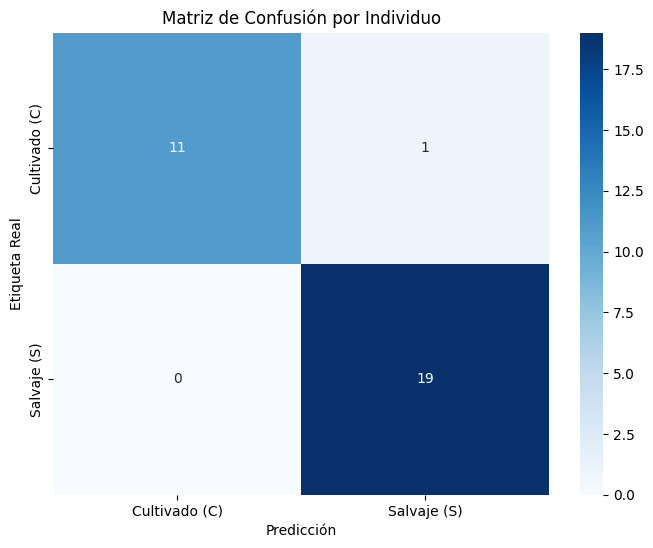

Reporte de Clasificación:
               precision    recall  f1-score   support

Cultivado (C)       1.00      0.92      0.96        12
  Salvaje (S)       0.95      1.00      0.97        19

     accuracy                           0.97        31
    macro avg       0.97      0.96      0.97        31
 weighted avg       0.97      0.97      0.97        31



In [50]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Configuración de carpetas y etiquetas
folders = {
    "S": r"C:\Users\Tech4Diet\Desktop\GLORIA\IJCNN\Dataset_I\S_aurata\test\C",  # Salvaje
    "C": r"C:\Users\Tech4Diet\Desktop\GLORIA\IJCNN\Dataset_I\S_aurata\test\S"   # Cultivado
}

image_size = (224, 224)  # Tamaño esperado por la red

# Función para procesar imágenes
def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalización
    return np.expand_dims(img_array, axis=0)

# Función para obtener el identificador del individuo
def get_individual_name(file_name):
    return file_name.split('(')[0].strip()

# Diccionarios para almacenar datos por individuo
individual_results = defaultdict(list)
true_labels = {}

# Procesar cada carpeta
for label, (group, folder_path) in enumerate(folders.items()):  # 0 para "S", 1 para "C"
    for file_name in sorted(os.listdir(folder_path)):
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Filtrar imágenes
            individual_name = get_individual_name(file_name)
            image_path = os.path.join(folder_path, file_name)
            processed_img = preprocess_image(image_path, image_size)
            logits = model.predict(processed_img, verbose=0)[0]  # Obtener logits
            probabilities = softmax(logits)  # Convertir logits a probabilidades
            
            # Almacenar probabilidades por individuo
            individual_results[individual_name].append(probabilities)
            true_labels[individual_name] = label  # Asignar etiqueta verdadera al individuo

# Calcular la clase promedio por individuo
predicted_labels = {}
for individual, probabilities in individual_results.items():
    avg_probabilities = np.mean(probabilities, axis=0)  # Promedio de probabilidades
    predicted_labels[individual] = np.argmax(avg_probabilities)  # Clase predicha

# Generar etiquetas reales y predichas para la matriz de confusión
y_true = [true_labels[ind] for ind in predicted_labels.keys()]
y_pred = [predicted_labels[ind] for ind in predicted_labels.keys()]

# Crear matriz de confusión
labels = ["Cultivado (C)","Salvaje (S)"]
cm = confusion_matrix(y_true, y_pred)

# Graficar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión por Individuo")
plt.show()

# Reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=labels))

In [51]:
base_dir = r"C:\Users\Tech4Diet\Desktop\GLORIA\IJCNN\Dataset_I\D_labrax"

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=90,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=[0.7, 1.3],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255)
#val_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
        os.path.join(base_dir, 'train'),
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
        class_mode='categorical')

'''
val_generator = val_datagen.flow_from_directory(
        os.path.join(base_dir, 'val'),
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        seed=42)
'''
test_generator = test_datagen.flow_from_directory(
        os.path.join(base_dir, 'test'),
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        shuffle=False,  
        class_mode='categorical')

print(f"Número de imágenes de entrenamiento: {train_generator.samples}")
#print(f"Número de imágenes de validación: {val_generator.samples}")
print(f"Número de imágenes de prueba: {test_generator.samples}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Steps per epoch: {len(train_generator)}")
#print(f"Validation steps: {len(val_generator)}")

Found 1316 images belonging to 2 classes.
Found 287 images belonging to 2 classes.
Número de imágenes de entrenamiento: 1316
Número de imágenes de prueba: 287
Batch size: 64
Steps per epoch: 21


In [52]:
from sklearn.utils import class_weight 
import numpy as np

print(np.unique(train_generator.classes))

class_weights = class_weight.compute_class_weight(
           'balanced',
            classes=np.unique(train_generator.classes), 
            y=train_generator.classes)

train_class_weights = dict(enumerate(class_weights))

train_class_weights = (class_weights)

print("Pesos de las clases:", train_class_weights)

[0 1]
Pesos de las clases: [0.83185841 1.25333333]


In [53]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

for layer in base_model.layers:
    if "block_16" in layer.name:  # Identifica las capas del último bloque
        layer.trainable = True

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])


# https://gist.github.com/wassname/ce364fddfc8a025bfab4348cf5de852d
def weighted_categorical_crossentropy(weights):
    def loss(y_true, y_pred):
        weights_tensor = tf.convert_to_tensor(weights, dtype=tf.float32)
        loss=tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred)
        class_weights = tf.reduce_sum(y_true * weights_tensor, axis=-1)
        weighted_loss = loss * class_weights
        return tf.reduce_mean(weighted_loss)

    return loss

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=weighted_categorical_crossentropy(train_class_weights),
    metrics=['accuracy']
)

callbacks = [
    TensorBoard(log_dir='./logs', histogram_freq=1),
    CSVLogger('training_log.csv', append=True, separator=';'),
]

In [54]:
try:
    history=model.fit(train_generator,
            #validation_data=val_generator,
            shuffle=True,
            epochs=EPOCHS,
            callbacks=callbacks)
    assert False
except Exception as e:
  print(f"Expected {type(e).__name__}: {e}")

Epoch 1/30
21/21 [==============================] - 8s 292ms/step - loss: 0.7711 - accuracy: 0.5684
Epoch 2/30
21/21 [==============================] - 6s 303ms/step - loss: 0.6040 - accuracy: 0.6664
Epoch 3/30
21/21 [==============================] - 6s 297ms/step - loss: 0.5566 - accuracy: 0.7166
Epoch 4/30
21/21 [==============================] - 6s 299ms/step - loss: 0.4837 - accuracy: 0.7682
Epoch 5/30
21/21 [==============================] - 6s 308ms/step - loss: 0.4405 - accuracy: 0.7926
Epoch 6/30
21/21 [==============================] - 6s 300ms/step - loss: 0.4144 - accuracy: 0.8078
Epoch 7/30
21/21 [==============================] - 6s 304ms/step - loss: 0.4109 - accuracy: 0.8199
Epoch 8/30
21/21 [==============================] - 6s 297ms/step - loss: 0.4101 - accuracy: 0.8108
Epoch 9/30
21/21 [==============================] - 6s 311ms/step - loss: 0.3915 - accuracy: 0.8191
Epoch 10/30
21/21 [==============================] - 6s 297ms/step - loss: 0.3893 - accuracy: 0.8267

In [55]:
# Save model
model.save('mobile_d_labrax_model.h5')

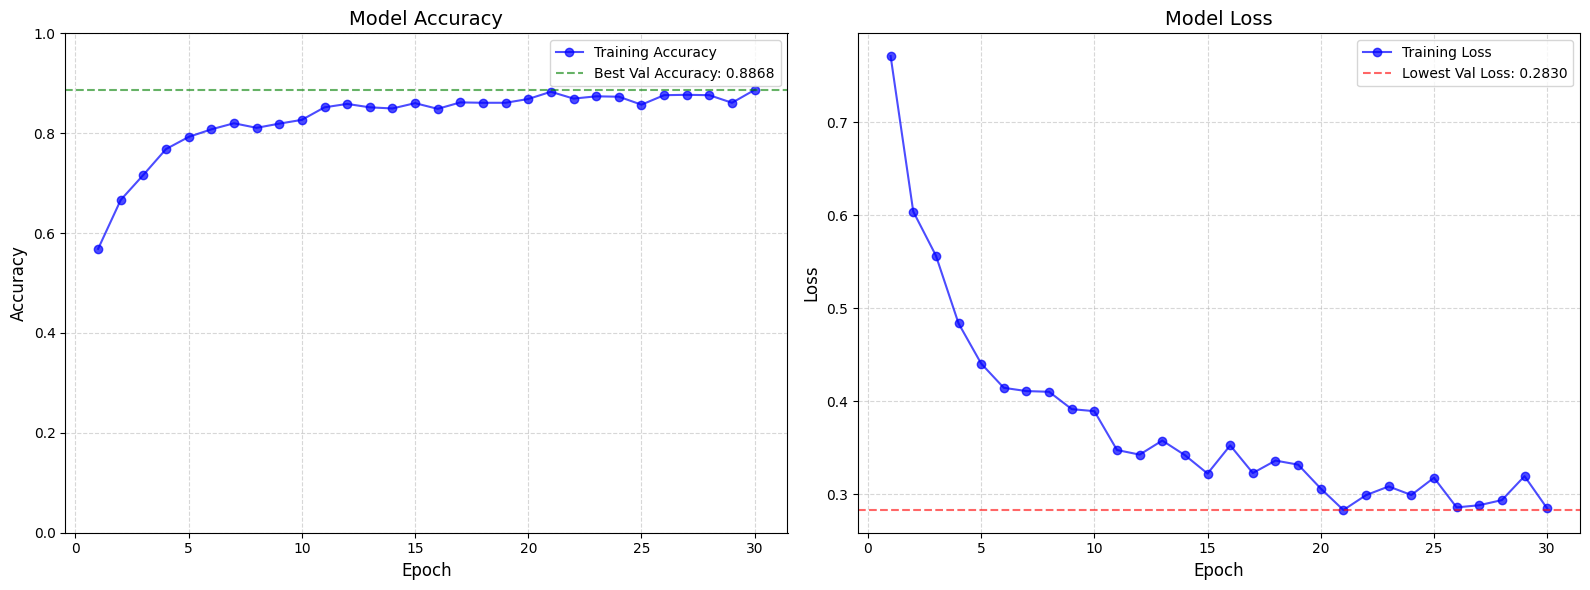

In [56]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(history):
    """
    Plot training history metrics with improved visualization.
    """
    # Obtener los datos
    epochs = range(1, len(history.history['accuracy']) + 1)
    train_acc = history.history['accuracy']
    #val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    #val_loss = history.history['val_loss']

    # Crear la figura
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Gráfica de Accuracy
    ax1.plot(epochs, train_acc, label='Training Accuracy', color='blue', linestyle='-', marker='o', alpha=0.7)
    #ax1.plot(epochs, val_acc, label='Validation Accuracy', color='orange', linestyle='-', marker='o', alpha=0.7)
    ax1.axhline(y=np.max(train_acc), color='green', linestyle='--', alpha=0.6, label=f"Best Val Accuracy: {np.max(train_acc):.4f}")
    ax1.set_title('Model Accuracy', fontsize=14)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(True, linestyle='--', alpha=0.5)
    ax1.set_ylim(0, 1)

    # Gráfica de Loss
    ax2.plot(epochs, train_loss, label='Training Loss', color='blue', linestyle='-', marker='o', alpha=0.7)
    #ax2.plot(epochs, val_loss, label='Validation Loss', color='orange', linestyle='-', marker='o', alpha=0.7)
    ax2.axhline(y=np.min(train_loss), color='red', linestyle='--', alpha=0.6, label=f"Lowest Val Loss: {np.min(train_loss):.4f}")
    ax2.set_title('Model Loss', fontsize=14)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend(fontsize=10)
    ax2.grid(True, linestyle='--', alpha=0.5)

    # Ajustar los márgenes y mostrar
    plt.tight_layout()
    plt.show()

plot_training_history(history)

5/5 [==============================] - 1s 75ms/step


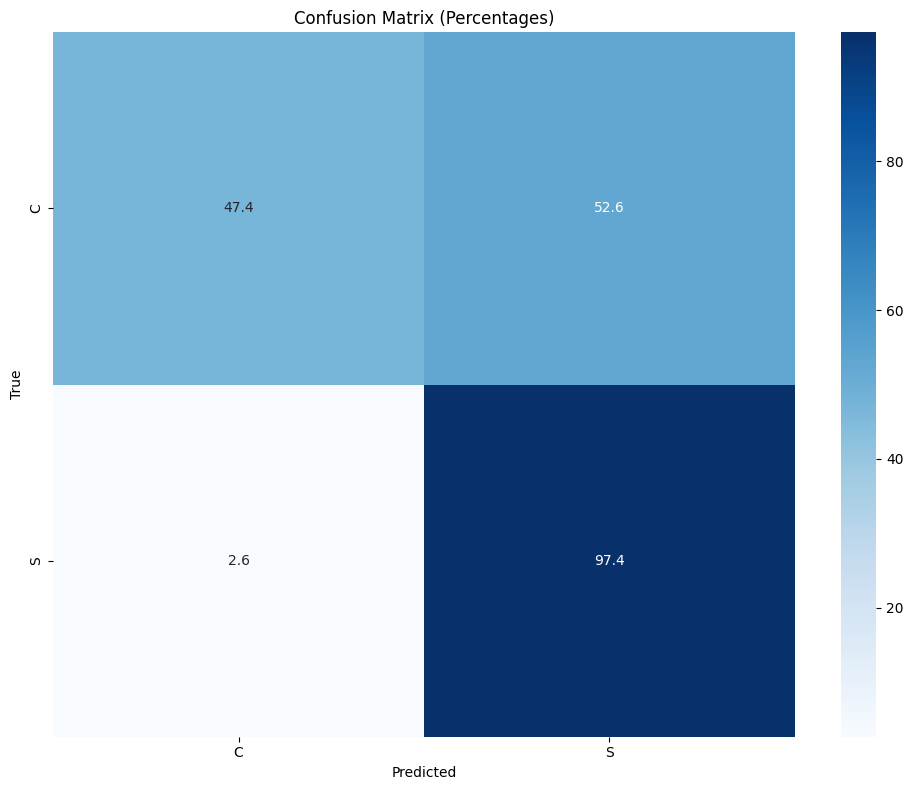


Detailed Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

           C       0.98      0.47      0.64       211
           S       0.40      0.97      0.57        76

    accuracy                           0.61       287
   macro avg       0.69      0.72      0.60       287
weighted avg       0.83      0.61      0.62       287



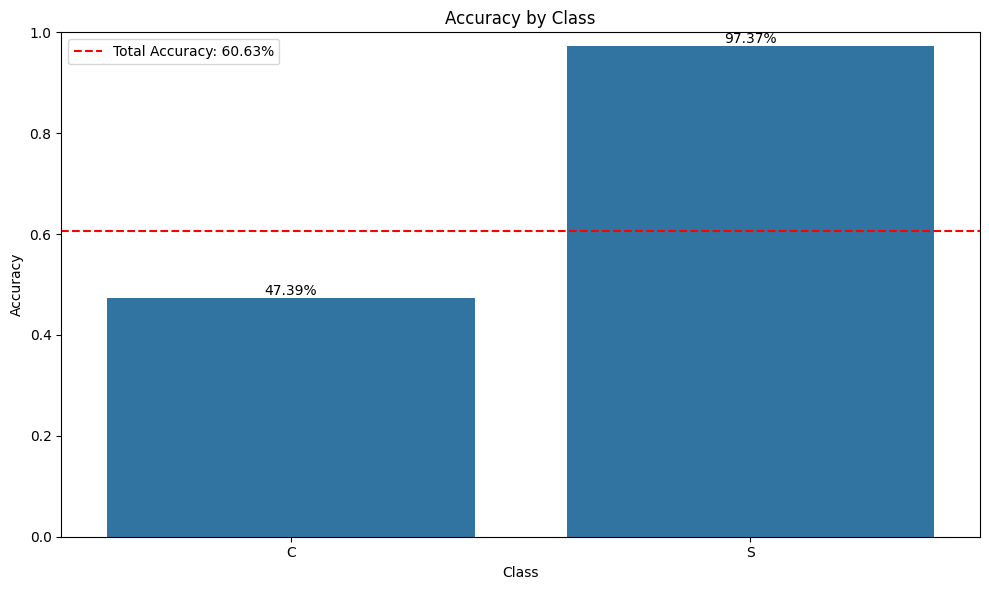

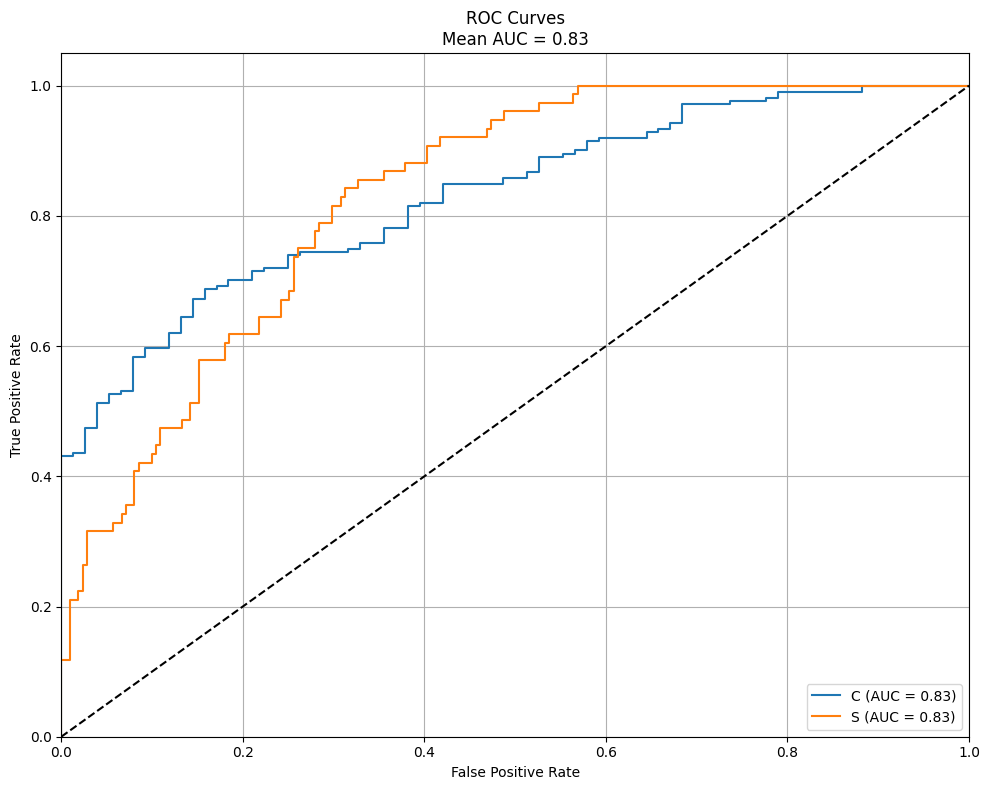


Summary Metrics:
--------------------------------------------------
Total Accuracy: 60.63%
Mean AUC: 0.83

Per-class Accuracy:
C: 47.39%
S: 97.37%


In [57]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf

def evaluate_model(model, test_generator):
    """
    Evaluate model and generate confusion matrix and classification report
    """
    # Get predictions
    test_generator.reset()
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())
    
    # Calcular matriz de confusión
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Convertir a porcentajes
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Visualización
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_percentage, annot=True, fmt='.1f', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.title('Confusion Matrix (Percentages)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
    
    # Print classification report
    print("\nDetailed Classification Report:")
    print("-"*50)
    print(classification_report(y_true, y_pred_classes, target_names=class_labels))
    
    # Calculate per-class accuracy
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

    total_accuracy = accuracy_score(y_true, y_pred_classes)
    
    # Plot per-class accuracy
    plt.figure(figsize=(10, 6))
    bars = sns.barplot(x=class_labels, y=per_class_accuracy)
    plt.axhline(y=total_accuracy, color='r', linestyle='--', label=f'Total Accuracy: {total_accuracy:.2%}')
    plt.title('Accuracy by Class')
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    
    # Add value labels on bars
    for i, acc in enumerate(per_class_accuracy):
        plt.text(i, acc, f'{acc:.2%}', ha='center', va='bottom')
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # ROC curve for each class
    from sklearn.metrics import roc_curve, auc
    plt.figure(figsize=(10, 8))
    
    mean_auc = 0
    for i, class_name in enumerate(class_labels):
        fpr, tpr, _ = roc_curve(
            (y_true == i).astype(int),
            y_pred[:, i]
        )
        roc_auc = auc(fpr, tpr)
        mean_auc += roc_auc
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
    
    mean_auc /= len(class_labels)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves\nMean AUC = {mean_auc:.2f}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Additional metrics summary
    print("\nSummary Metrics:")
    print("-"*50)
    print(f"Total Accuracy: {total_accuracy:.2%}")
    print(f"Mean AUC: {mean_auc:.2f}")
    print("\nPer-class Accuracy:")
    for class_name, acc in zip(class_labels, per_class_accuracy):
        print(f"{class_name}: {acc:.2%}")

evaluate_model(model, test_generator)

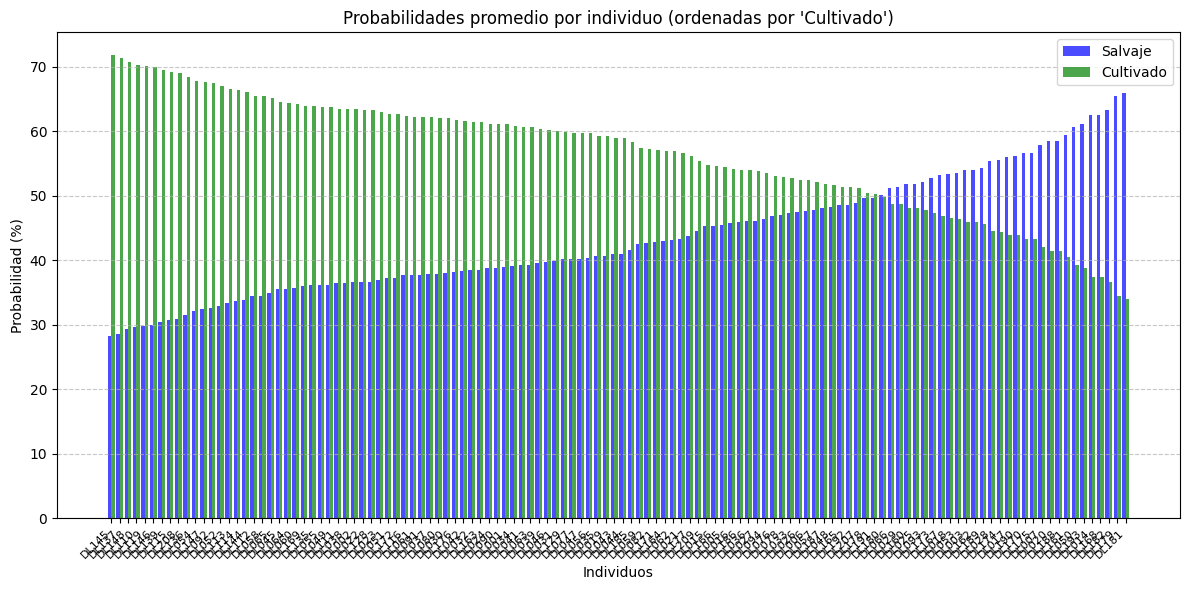

Probabilidad total de 'Salvaje': 43.57%
Probabilidad total de 'Cultivado': 56.43%


In [58]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from scipy.special import softmax
from collections import defaultdict

images_folder = r"C:\Users\Tech4Diet\Desktop\GLORIA\IJCNN\Dataset_I\D_Labrax\E"
image_size = (224, 224)  # Tamaño esperado por la red

# Función para procesar imágenes
def preprocess_image(image_path, target_size):
    """Preprocesa una imagen para que sea compatible con el modelo."""
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalización
    return np.expand_dims(img_array, axis=0)

# Función para procesar imágenes
def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalización
    return np.expand_dims(img_array, axis=0)

# Extraer el identificador del individuo (parte antes de "(" en el nombre)
def get_individual_name(file_name):
    return file_name.split('(')[0].strip()

# Procesar todas las imágenes y agrupar por individuo
results = defaultdict(list)  # Diccionario para almacenar probabilidades por individuo
image_groups = defaultdict(list)  # Diccionario para agrupar nombres de archivos por individuo
for file_name in sorted(os.listdir(images_folder)):
    if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Filtrar imágenes
        individual_name = get_individual_name(file_name)  # Identificar individuo
        image_path = os.path.join(images_folder, file_name)
        processed_img = preprocess_image(image_path, image_size)
        logits = model.predict(processed_img, verbose=0)[0]  # Obtener logits
        probabilities = softmax(logits)  # Convertir logits a probabilidades
        results[individual_name].append(probabilities)  # Agrupar por individuo
        image_groups[individual_name].append(file_name)  # Almacenar nombres

# Calcular promedio de probabilidades por individuo
individual_averages = {ind: np.mean(probs, axis=0) for ind, probs in results.items()}
sorted_individuals = sorted(individual_averages.items(), key=lambda x: x[1][1], reverse=True)

# Separar nombres y probabilidades ya ordenados
individual_names = [ind for ind, _ in sorted_individuals]
wild_probabilities = [probs[0] * 100 for _, probs in sorted_individuals]  # Salvaje (%)
cultivated_probabilities = [probs[1] * 100 for _, probs in sorted_individuals]  # Cultivado (%)

# Graficar resultados agrupados por individuo (ordenados)
x = np.arange(len(sorted_individuals))  # Índices de individuos
plt.figure(figsize=(12, 6))
plt.bar(x - 0.2, wild_probabilities, width=0.4, label="Salvaje", color='blue', alpha=0.7)
plt.bar(x + 0.2, cultivated_probabilities, width=0.4, label="Cultivado", color='green', alpha=0.7)
plt.xticks(x, individual_names, rotation=45, ha='right', fontsize=8)
plt.ylabel("Probabilidad (%)")
plt.xlabel("Individuos")
plt.title("Probabilidades promedio por individuo (ordenadas por 'Cultivado')")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Agregar rejilla para claridad
plt.show()

total_wild = sum(probs[0] for probs in individual_averages.values()) * 100 /len(individual_averages)  # Salvaje (%)
total_cultivated = sum(probs[1] for probs in individual_averages.values()) * 100 /len(individual_averages) # Cultivado (%)

print(f"Probabilidad total de 'Salvaje': {total_wild:.2f}%")
print(f"Probabilidad total de 'Cultivado': {total_cultivated:.2f}%")

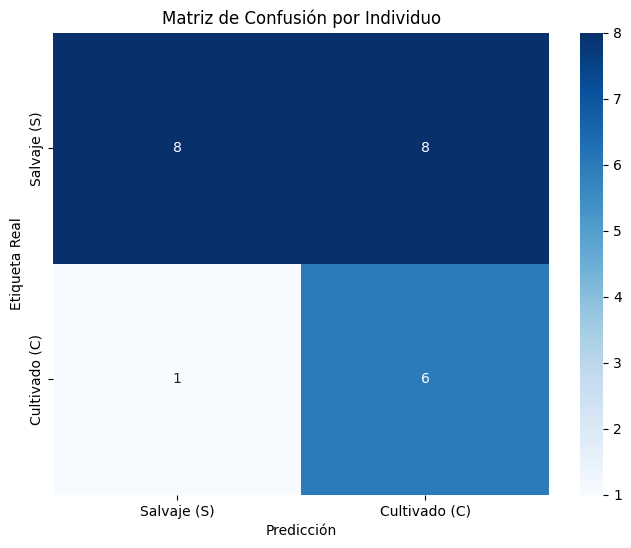

Reporte de Clasificación:
               precision    recall  f1-score   support

  Salvaje (S)       0.89      0.50      0.64        16
Cultivado (C)       0.43      0.86      0.57         7

     accuracy                           0.61        23
    macro avg       0.66      0.68      0.61        23
 weighted avg       0.75      0.61      0.62        23



In [60]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Configuración de carpetas y etiquetas
folders = {
    "S": r"C:\Users\Tech4Diet\Desktop\GLORIA\IJCNN\Dataset_I\D_Labrax\test\C",  # Salvaje
    "C": r"C:\Users\Tech4Diet\Desktop\GLORIA\IJCNN\Dataset_I\D_Labrax\test\S"   # Cultivado
}

image_size = (224, 224)  # Tamaño esperado por la red

# Función para procesar imágenes
def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalización
    return np.expand_dims(img_array, axis=0)

# Función para obtener el identificador del individuo
def get_individual_name(file_name):
    return file_name.split('(')[0].strip()

# Diccionarios para almacenar datos por individuo
individual_results = defaultdict(list)
true_labels = {}

# Procesar cada carpeta
for label, (group, folder_path) in enumerate(folders.items()):  # 0 para "S", 1 para "C"
    for file_name in sorted(os.listdir(folder_path)):
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Filtrar imágenes
            individual_name = get_individual_name(file_name)
            image_path = os.path.join(folder_path, file_name)
            processed_img = preprocess_image(image_path, image_size)
            logits = model.predict(processed_img, verbose=0)[0]  # Obtener logits
            probabilities = softmax(logits)  # Convertir logits a probabilidades
            
            # Almacenar probabilidades por individuo
            individual_results[individual_name].append(probabilities)
            true_labels[individual_name] = label  # Asignar etiqueta verdadera al individuo

# Calcular la clase promedio por individuo
predicted_labels = {}
for individual, probabilities in individual_results.items():
    avg_probabilities = np.mean(probabilities, axis=0)  # Promedio de probabilidades
    predicted_labels[individual] = np.argmax(avg_probabilities)  # Clase predicha

# Generar etiquetas reales y predichas para la matriz de confusión
y_true = [true_labels[ind] for ind in predicted_labels.keys()]
y_pred = [predicted_labels[ind] for ind in predicted_labels.keys()]

# Crear matriz de confusión
labels = ["Cultivado (C)","Salvaje (S)"]
cm = confusion_matrix(y_true, y_pred)

# Graficar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión por Individuo")
plt.show()

# Reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=labels))